## Crime Type Prediction- XGBOOST & Random Forest

In [1]:
# Data Preprocessing for Crime Type Prediction

import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn import set_config

import warnings
warnings.filterwarnings("ignore")
set_config(transform_output="default")

# Load Data
df = pd.read_csv("Crime_Data_Preprocessed.csv")

print("Data loaded. Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Convert dates
for col in ["date_occ", "date_rptd"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# 4-Class Crime Category Mapping
def map_crime_category(crm_desc: str) -> str:
    if pd.isna(crm_desc):
        base = "Other"
    else:
        d = crm_desc.upper()
        violent_keywords = [
            "RAPE", "SEXUAL", "HOMICIDE", "MANSLAUGHTER", "KIDNAPPING",
            "BRANDISH", "CRIMINAL THREATS", "THREAT", "SHOTS FIRED",
            "CHILD ABUSE", "ELDER ABUSE", "ELDER_ABUSE", "ARSON"
        ]
        if any(k in d for k in violent_keywords):
            base = "Other violent"
        elif "ROBBERY" in d or "CARJACKING" in d:
            base = "Robbery"
        elif "ASSAULT" in d or "BATTERY" in d or "INTIMATE PARTNER" in d:
            base = "Assault"
        elif "BURGLARY" in d:
            base = "Burglary"
        else:
            theft_keywords = ["THEFT", "STOLEN", "SHOPLIFTING", "PURSE SNATCHING",
                               "EMBEZZLEMENT", "BUNCO", "BIKE - STOLEN", "VEHICLE - STOLEN"]
            if any(k in d for k in theft_keywords):
                base = "Theft"
            else:
                property_keywords = ["VANDALISM", "TRESPASS", "TAMPERING",
                                     "DUMPING", "GRAFFITI", "PROPERTY"]
                if any(k in d for k in property_keywords):
                    base = "Property (non-theft)"
                else:
                    base = "Other"

    if base in ["Assault", "Robbery", "Other violent"]:
        return "Assault"
    elif base == "Theft":
        return "Theft"
    elif base == "Burglary":
        return "Burglary"
    else:
        return "Others"

df["crime_category"] = df["crm_cd_desc"].apply(map_crime_category)

print("\n4-Class Category Distribution (%):")
print((df["crime_category"].value_counts(normalize=True) * 100).round(2))

# Feature Engineering
df["year"] = df["date_occ"].dt.year
df["month"] = df["date_occ"].dt.month
df["day"] = df["date_occ"].dt.day
df["day_of_week"] = df["date_occ"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

if "hour" in df.columns:
    pass
elif "time_occ_clean" in df.columns:
    df["hour"] = df["time_occ_clean"] // 100
elif "time_occ" in df.columns:
    df["hour"] = df["time_occ"] // 100
else:
    df["hour"] = np.nan

# Weapon grouping
def map_weapon_group(desc: str) -> str:
    if pd.isna(desc): return "Weapon_Unknown"
    d = desc.upper()
    if any(k in d for k in ["HAND GUN", "RIFLE", "SHOTGUN", "REVOLVER", "SEMI-AUTOMATIC", "FIREARM"]):
        return "Firearm"
    if any(k in d for k in ["KNIFE", "SHARP", "MACHETE", "SWORD", "AXE"]):
        return "Knife/Sharp"
    if any(k in d for k in ["BLUNT", "PIPE", "CLUB", "BAT", "HAMMER"]):
        return "Blunt"
    if any(k in d for k in ["STRONG-ARM", "HANDS", "FIST", "FEET"]):
        return "Body force"
    if "VERBAL" in d or "THREAT" in d:
        return "Verbal threat"
    if any(k in d for k in ["VEHICLE", "CAR", "AUTO"]):
        return "Vehicle as weapon"
    return "Weapon_Other"

df["weapon_group"] = (
    df["weapon_desc"].apply(map_weapon_group)
    if "weapon_desc" in df.columns else "Weapon_Unknown"
)

# Premises grouping
def map_premise_group(desc: str) -> str:
    if pd.isna(desc): return "Premises_Unknown"
    d = desc.upper()
    if any(k in d for k in ["SINGLE FAMILY", "APARTMENT", "RESIDENCE", "HOUSE"]):
        return "Residential"
    if any(k in d for k in ["STREET", "SIDEWALK", "ALLEY", "PARK", "PARKING", "LOT"]):
        return "Street/Outdoor"
    if any(k in d for k in ["STORE", "MARKET", "MALL", "RESTAURANT", "BAR", "CLUB", "GAS STATION"]):
        return "Retail/Commercial"
    if any(k in d for k in ["BUS", "SUBWAY", "TRAIN", "STATION", "AIRPORT", "METRO"]):
        return "Transit"
    if any(k in d for k in ["SCHOOL", "COLLEGE", "UNIVERSITY", "HOSPITAL", "POLICE STATION", "CHURCH"]):
        return "Public institution"
    return "Premises_Other"

df["premis_group"] = (
    df["premis_desc"].apply(map_premise_group)
    if "premis_desc" in df.columns else "Premises_Unknown"
)

# Drop Leakage columns
drop_cols = ["crm_cd", "crm_cd_desc", "crm_cd_1", "dr_no", "status_desc", "date_rptd"]

for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

target_col = "crime_category"
feature_cols = [c for c in df.columns if c not in [target_col, "date_occ"]]

print("Data processing completed")

Data loaded. Shape: (1004991, 26)
Columns: ['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name', 'rpt_dist_no', 'crm_cd', 'crm_cd_desc', 'vict_age', 'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc', 'weapon_desc', 'status_desc', 'crm_cd_1', 'location', 'cross_street', 'lat', 'lon', 'time_occ_clean', 'year', 'month', 'day', 'hour']

4-Class Category Distribution (%):
crime_category
Theft       41.72
Assault     29.02
Others      16.72
Burglary    12.54
Name: proportion, dtype: float64
Data processing completed


In [2]:
# Year based train/val/test split


boundary_train_end = pd.Timestamp("2023-01-01")
boundary_val_end = pd.Timestamp("2024-01-01")

df_sorted = df.sort_values("date_occ")

train = df_sorted[df_sorted["date_occ"] < boundary_train_end]
val   = df_sorted[(df_sorted["date_occ"] >= boundary_train_end) & (df_sorted["date_occ"] < boundary_val_end)]
test  = df_sorted[df_sorted["date_occ"] >= boundary_val_end]

X_train = train[feature_cols]
y_train = train[target_col]

X_val = val[feature_cols]
y_val = val[target_col]

X_test = test[feature_cols]
y_test = test[target_col]

print("\nSplit sizes (train, val, test):", len(train), len(val), len(test))



Split sizes (train, val, test): 644982 232345 127664


In [3]:
# XGBoost Model Training with Optuna Hyperparameter Tuning

import joblib
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

os.makedirs("crime_xgb_model", exist_ok=True)
MODEL_PATH = "crime_xgb_model/xgb_pipeline.pkl"
ENC_PATH = "crime_xgb_model/xgb_label_encoder.pkl"

if os.path.exists(MODEL_PATH) and os.path.exists(ENC_PATH):
    print("XGBoost model already exists.")
    xgb_pipeline = joblib.load(MODEL_PATH)
    label_encoder = joblib.load(ENC_PATH)
    print("XGBoost model loaded successfully.")
else:
    print("No saved XGBoost model found, training new model.")

    numeric_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
    categorical_features = [c for c in X_train.columns if c not in numeric_features]

    preprocessor = ColumnTransformer([
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_features),
    ])
    preprocessor.fit(X_train)

    X_train_trans = preprocessor.transform(X_train)

    # Class weights
    classes = np.unique(y_train)
    class_weights = compute_class_weight("balanced", classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    sample_weight_train = y_train.map(class_weight_dict).to_numpy()

    label_encoder = LabelEncoder()
    y_train_enc = label_encoder.fit_transform(y_train)

    # Optuna hyperparameter training
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "eta": trial.suggest_float("eta", 0.01, 0.2, log=True),
            "lambda": trial.suggest_float("lambda", 0.0, 3.0),
            "alpha": trial.suggest_float("alpha", 0.0, 2.0),
            "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        }

        clf = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=len(classes),
            eval_metric="mlogloss",
            tree_method="hist",
            **params
        )

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        f1_scores = []

        for train_idx, valid_idx in skf.split(X_train_trans, y_train_enc):
            X_tr = X_train_trans[train_idx]
            X_va = X_train_trans[valid_idx]
            y_tr = y_train_enc[train_idx]
            y_va = y_train_enc[valid_idx]

            w_tr = sample_weight_train[train_idx]

            clf.fit(X_tr, y_tr, sample_weight=w_tr)
            preds = clf.predict(X_va)
            f1_scores.append(f1_score(y_va, preds, average="macro"))

        return float(np.mean(f1_scores))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    best_params = study.best_params
    print("Best XGBoost params:", best_params)

    # Final model training on train + val
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])

    sample_weight_train_val = y_train_val.map(class_weight_dict).to_numpy()
    y_train_val_enc = label_encoder.fit_transform(y_train_val)

    final_preprocessor = ColumnTransformer([
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_features),
    ])
    final_preprocessor.fit(X_train_val)
    X_train_val_trans = final_preprocessor.transform(X_train_val)

    final_model = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=len(classes),
        eval_metric="mlogloss",
        tree_method="hist",
        **best_params
    )

    final_model.fit(X_train_val_trans, y_train_val_enc, sample_weight=sample_weight_train_val)

    # Save the pipeline and label encoder
    xgb_pipeline = Pipeline([
        ("preprocess", final_preprocessor),
        ("model", final_model)
    ])

    joblib.dump(xgb_pipeline, MODEL_PATH)
    joblib.dump(label_encoder, ENC_PATH)

    print("Saved XGBoost model successfully.")


No saved XGBoost model found, training new model.


[I 2025-12-12 11:41:16,796] A new study created in memory with name: no-name-3705b6b4-ca41-4d0f-8dd7-c2c290642267
[I 2025-12-12 11:50:14,106] Trial 0 finished with value: 0.6930298158864665 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.831099041721774, 'colsample_bytree': 0.7400220736033556, 'eta': 0.061079108328141236, 'lambda': 2.9322050103376434, 'alpha': 0.6239980205534654, 'n_estimators': 541}. Best is trial 0 with value: 0.6930298158864665.
[I 2025-12-12 12:09:30,759] Trial 1 finished with value: 0.6843818780239825 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.642188209826933, 'colsample_bytree': 0.9206002337183887, 'eta': 0.02436250107797919, 'lambda': 0.8928386913148489, 'alpha': 0.17498799300618773, 'n_estimators': 647}. Best is trial 0 with value: 0.6930298158864665.
[I 2025-12-12 12:17:44,277] Trial 2 finished with value: 0.7046445405567878 and parameters: {'max_depth': 10, 'min_child_weight': 16, 'subsample': 0.947653103159

Best XGBoost params: {'max_depth': 9, 'min_child_weight': 15, 'subsample': 0.9325054435723159, 'colsample_bytree': 0.6016424750946998, 'eta': 0.19149900527909114, 'lambda': 2.2982960215940675, 'alpha': 1.6983744979742421, 'n_estimators': 893}
Saved XGBoost model successfully.


In [4]:
# Random Forest Model Training with Optuna Hyperparameter Tuning

import joblib
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

os.makedirs("crime_rf_model", exist_ok=True)
RF_MODEL_PATH = "crime_rf_model/rf_pipeline.pkl"
RF_ENC_PATH   = "crime_rf_model/rf_label_encoder.pkl"

if os.path.exists(RF_MODEL_PATH) and os.path.exists(RF_ENC_PATH):
    print("model already exists.")
    rf_pipeline = joblib.load(RF_MODEL_PATH)
    rf_label_encoder = joblib.load(RF_ENC_PATH)
    print("Random Forest model loaded successfully.")

else:
    print("No saved Random Forest model found, training new model.")

    numeric_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
    categorical_features = [c for c in X_train.columns if c not in numeric_features]

    preprocessor = ColumnTransformer([
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_features),
    ])
    preprocessor.fit(X_train)

    X_train_trans = preprocessor.transform(X_train)

    # Label encoding + class weights
    rf_label_encoder = LabelEncoder()
    y_train_enc = rf_label_encoder.fit_transform(y_train)

    classes = np.unique(y_train_enc)
    class_weights = compute_class_weight("balanced", classes=classes, y=y_train_enc)
    class_weight_dict = dict(zip(classes, class_weights))

    # Optuna function for cross-validation
    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 150, 350),
            "max_depth": trial.suggest_int("max_depth", 7, 18),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 18),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 8),
            "max_samples": trial.suggest_float("max_samples", 0.50, 0.85),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            "bootstrap": True,
            "n_jobs": -1,
            "class_weight": class_weight_dict,
            "random_state": 42
        }

        clf = RandomForestClassifier(**params)

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        f1_scores = []

        for train_idx, valid_idx in skf.split(X_train_trans, y_train_enc):
            X_tr = X_train_trans[train_idx]
            X_va = X_train_trans[valid_idx]
            y_tr = y_train_enc[train_idx]
            y_va = y_train_enc[valid_idx]

            clf.fit(X_tr, y_tr)
            preds = clf.predict(X_va)

            f1_scores.append(f1_score(y_va, preds, average="macro"))

        return float(np.mean(f1_scores))

    # Optuna hyperparameter search 
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)

    best_params = study.best_params
    print("\nBest Random Forest Parameters:")
    print(best_params)

    # Final training on train + val (same as XGBoost pipeline)
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    y_train_val_enc = rf_label_encoder.fit_transform(y_train_val)

    final_preprocessor = ColumnTransformer([
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_features),
    ])
    final_preprocessor.fit(X_train_val)
    X_train_val_trans = final_preprocessor.transform(X_train_val)

    rf_final = RandomForestClassifier(
        **best_params,
        class_weight=class_weight_dict,
        n_jobs=-1,
        random_state=42
    )

    rf_final.fit(X_train_val_trans, y_train_val_enc)

    # Save the model pipeline and label encoder
    rf_pipeline = Pipeline([
        ("preprocess", final_preprocessor),
        ("model", rf_final)
    ])

    joblib.dump(rf_pipeline, RF_MODEL_PATH)
    joblib.dump(rf_label_encoder, RF_ENC_PATH)

    print("Random Forest model saved successfully.")


No saved Random Forest model found, training new model.


[I 2025-12-12 16:19:14,595] A new study created in memory with name: no-name-8dfac642-1ea3-4e45-a8a5-29ffa643bd31
[I 2025-12-12 16:20:27,505] Trial 0 finished with value: 0.6172848733002051 and parameters: {'n_estimators': 279, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_samples': 0.5996404888929129, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6172848733002051.
[I 2025-12-12 16:21:37,560] Trial 1 finished with value: 0.6167690867116208 and parameters: {'n_estimators': 260, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_samples': 0.6129458302758969, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6172848733002051.
[I 2025-12-12 16:22:29,928] Trial 2 finished with value: 0.6173303055741077 and parameters: {'n_estimators': 163, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_samples': 0.7447556617051898, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6173303055741077.
[I 2025-12-12 16:23:16,396] 


Best Random Forest Parameters:
{'n_estimators': 203, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_samples': 0.7202964394108943, 'max_features': 'sqrt'}
Random Forest model saved successfully.


Evaluating: XGBoost
Macro F1:        0.7272
Weighted F1:     0.7714
Precision (mac): 0.7118
Recall (mac):    0.7653
Macro AUC:       0.9324
Weighted AUC:    0.9329
Macro PR-AUC:    0.7999

Classification Report:
              precision    recall  f1-score   support

     Assault       0.94      0.96      0.95     20151
    Burglary       0.42      0.70      0.53     14346
      Others       0.57      0.65      0.61     22428
       Theft       0.91      0.75      0.82     70739

    accuracy                           0.76    127664
   macro avg       0.71      0.77      0.73    127664
weighted avg       0.80      0.76      0.77    127664



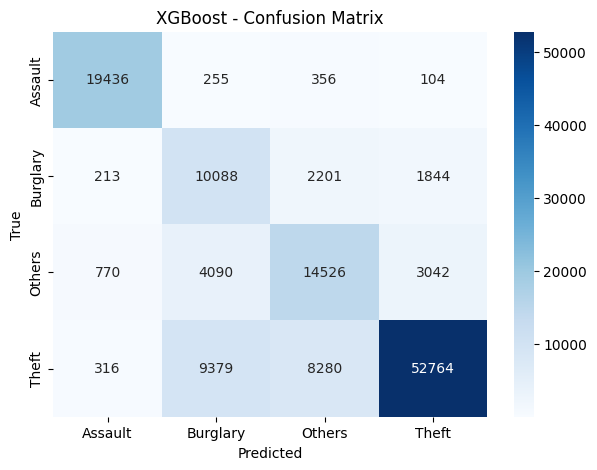

Evaluating: Random Forest
Macro F1:        0.6521
Weighted F1:     0.6974
Precision (mac): 0.6405
Recall (mac):    0.6937
Macro AUC:       0.8795
Weighted AUC:    0.8753
Macro PR-AUC:    0.7105

Classification Report:
              precision    recall  f1-score   support

     Assault       0.90      0.97      0.93     20151
    Burglary       0.33      0.58      0.42     14346
      Others       0.46      0.57      0.51     22428
       Theft       0.87      0.65      0.75     70739

    accuracy                           0.68    127664
   macro avg       0.64      0.69      0.65    127664
weighted avg       0.74      0.68      0.70    127664



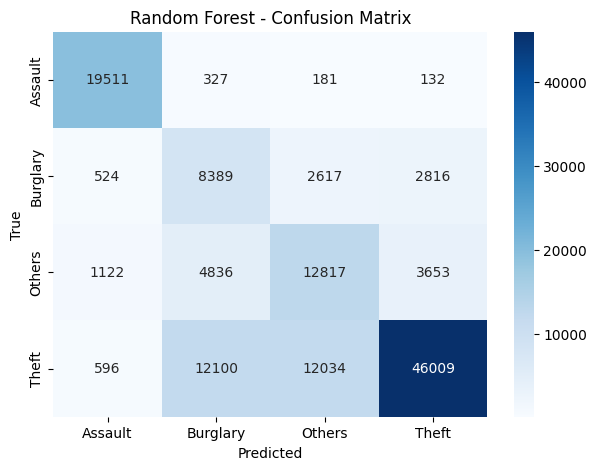

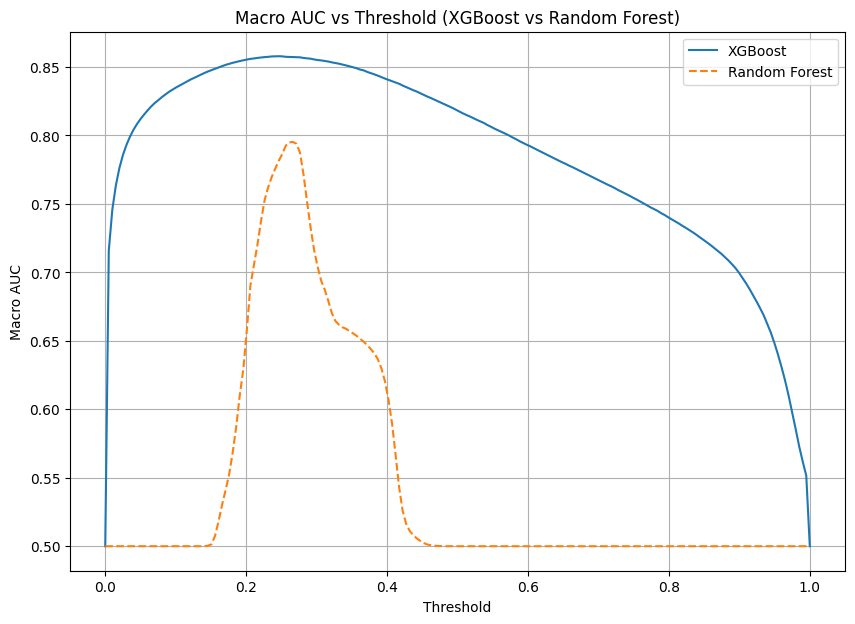

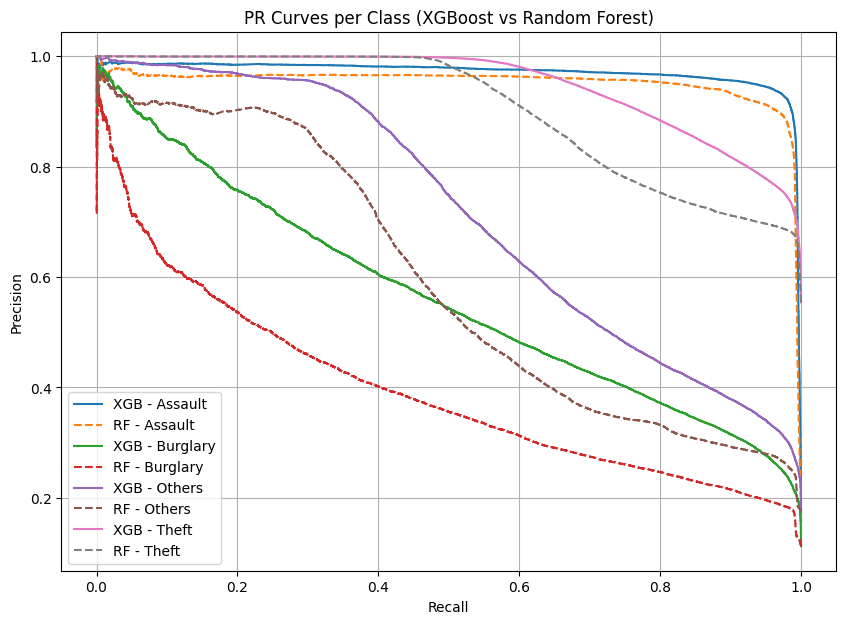

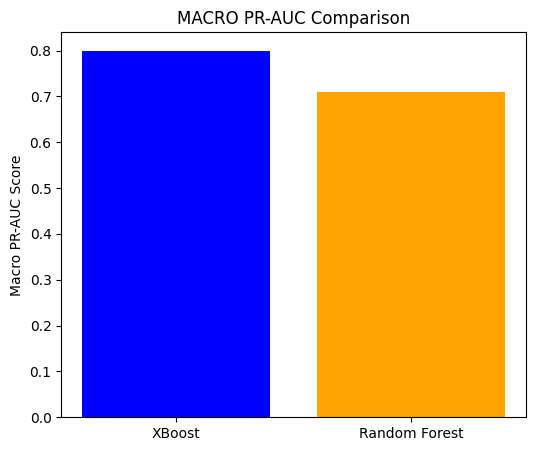

In [5]:
# Evaluation and Comparison of XGBoost and Random Forest Models

import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize

# Loading models
xgb_pipeline = joblib.load("crime_xgb_model/xgb_pipeline.pkl")
xgb_encoder  = joblib.load("crime_xgb_model/xgb_label_encoder.pkl")

rf_pipeline  = joblib.load("crime_rf_model/rf_pipeline.pkl")
rf_encoder   = joblib.load("crime_rf_model/rf_label_encoder.pkl")

models = {
    "XGBoost": (xgb_pipeline, xgb_encoder),
    "Random Forest": (rf_pipeline, rf_encoder)
}


for model_name, (pipeline, encoder) in models.items():

    print(f"Evaluating: {model_name}")
    

    X_test_trans = pipeline.named_steps["preprocess"].transform(X_test)

    y_test_enc = encoder.transform(y_test)
    y_pred_enc = pipeline.named_steps["model"].predict(X_test_trans)
    y_pred = encoder.inverse_transform(y_pred_enc)

    y_prob = pipeline.named_steps["model"].predict_proba(X_test_trans)

    y_test_bin = label_binarize(y_test_enc, classes=range(len(encoder.classes_)))

    macro_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    weighted_auc = roc_auc_score(y_test_bin, y_prob, average="weighted", multi_class="ovr")

    pr_aucs = []
    for i in range(len(encoder.classes_)):
        pr_auc = average_precision_score(y_test_bin[:, i], y_prob[:, i])
        pr_aucs.append(pr_auc)

    macro_pr_auc = np.mean(pr_aucs)

  # Model Evaluation Summary
    # print(f"Accuracy:        {accuracy_score(y_test, y_pred):.4f}")
    print(f"Macro F1:        {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Weighted F1:     {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Precision (mac): {precision_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
    print(f"Recall (mac):    {recall_score(y_test, y_pred, average='macro', zero_division=0):.4f}")
    print(f"Macro AUC:       {macro_auc:.4f}")
    print(f"Weighted AUC:    {weighted_auc:.4f}")
    print(f"Macro PR-AUC:    {macro_pr_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Model predictions for comparison plots
xgb_prob = xgb_pipeline.named_steps["model"].predict_proba(
    xgb_pipeline.named_steps["preprocess"].transform(X_test)
)

rf_prob = rf_pipeline.named_steps["model"].predict_proba(
    rf_pipeline.named_steps["preprocess"].transform(X_test)
)

y_test_enc = xgb_encoder.transform(y_test)
classes = xgb_encoder.classes_
y_test_bin = label_binarize(y_test_enc, classes=range(len(classes)))


plt.figure(figsize=(10, 7))

thresholds = np.linspace(0, 1, 200)
macro_auc_xgb = []
macro_auc_rf = []

# Macro AUC vs Threshold Comparison
for t in thresholds:
    y_pred_xgb = (xgb_prob >= t).astype(int)
    y_pred_rf  = (rf_prob  >= t).astype(int)

    # Macro AUC for both models
    auc_xgb = roc_auc_score(y_test_bin, y_pred_xgb, average="macro")
    auc_rf  = roc_auc_score(y_test_bin, y_pred_rf,  average="macro")

    macro_auc_xgb.append(auc_xgb)
    macro_auc_rf.append(auc_rf)

plt.plot(thresholds, macro_auc_xgb, label="XGBoost", linestyle="-")
plt.plot(thresholds, macro_auc_rf, label="Random Forest", linestyle="--")

plt.title("Macro AUC vs Threshold (XGBoost vs Random Forest)")
plt.xlabel("Threshold")
plt.ylabel("Macro AUC")
plt.legend()
plt.grid(True)
plt.show()


# Macro PR-AUC Curves Comparison 
plt.figure(figsize=(10, 7))

prec_xgb, rec_xgb = [], []
prec_rf, rec_rf = [], []

for i in range(len(classes)):
    pr_xgb = precision_recall_curve(y_test_bin[:, i], xgb_prob[:, i])
    pr_rf  = precision_recall_curve(y_test_bin[:, i], rf_prob[:, i])

    plt.plot(pr_xgb[1], pr_xgb[0], label=f"XGB - {classes[i]}", linestyle="-")
    plt.plot(pr_rf[1], pr_rf[0], label=f"RF - {classes[i]}", linestyle="--")

plt.title("PR Curves per Class (XGBoost vs Random Forest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

macro_pr_auc_xgb = np.mean([
    average_precision_score(y_test_bin[:, i], xgb_prob[:, i])
    for i in range(len(classes))
])

macro_pr_auc_rf = np.mean([
    average_precision_score(y_test_bin[:, i], rf_prob[:, i])
    for i in range(len(classes))
])

plt.figure(figsize=(6, 5))
plt.bar(["XBoost", "Random Forest"],
        [macro_pr_auc_xgb, macro_pr_auc_rf],
        color=["blue", "orange"])
plt.title("MACRO PR-AUC Comparison")
plt.ylabel("Macro PR-AUC Score")
plt.show()
